In [1]:
# remove warning messages

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 01. Data Preprocessing

import pandas as pd
from sklearn import preprocessing
from IPython.display import display, HTML

df=pd.read_csv('Malware_MultiClass.csv')
print(df.shape)
# strip column names
df=df.rename(columns=lambda x: x.strip())
cols=df.columns
# print out and display dataframe as tables in HTML
display(HTML(df.head(10).to_html()))
df_raw=df.copy(deep=True)

df=df.drop('hash',axis=1)
df=df.drop('millisecond',axis=1)
df=df.drop('state',axis=1)
df=df.drop('policy',axis=1)
df=df.drop('cached_hole_size',axis=1)
df=df.drop('free_area_cache',axis=1)
df=df.drop('mm_users',axis=1)
df=df.drop('end_data',axis=1)
df=df.drop('last_interval',axis=1)
df=df.drop('min_flt',axis=1)
df=df.drop('maj_flt',axis=1)
df=df.drop('fs_excl_counter',axis=1)
df=df.drop('lock',axis=1)
df=df.drop('utime',axis=1)
df=df.drop('stime',axis=1)
df=df.drop('gtime',axis=1)
df=df.drop('cgtime',axis=1)

display(HTML(df.head(10).to_html()))

# encode labels
y = df['classification'] # define label as nominal values
le = preprocessing.LabelEncoder()
le.fit(y)
y_encoded = le.transform(y) # encode nominal labels to integers #####################################
df['classification'] = y_encoded

# print out and display dataframe as tables in HTML
display(HTML(df.head(10).to_html()))

print('Column Datatypes:\n',df.dtypes)

# convert all nominal variables to binary variables
df_num=df.copy(deep=True) 
# create new binary columns
df_dummies=pd.get_dummies(df_num[['os']])
# add them to dataframe
df_num=df_num.join(df_dummies)
# drop original columns
df_num=df_num.drop('os',axis=1)

display(HTML(df_num.head(10).to_html()))

# drop extra binary columns, since we only need N-1 binary columns
df_num=df_num.drop('os_CentOS', axis=1)
display('df_num:',HTML(df_num.head(10).to_html()))


(100000, 36)


,hash,millisecond,classification,os,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
0,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,0,malware,CentOS,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
1,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,1,malware,Windows,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
2,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,2,malware,Mac,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
3,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,3,malware,Ubuntu,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
4,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,4,malware,Mac,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
5,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,5,malware,Windows,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
6,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,6,malware,Ubuntu,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
7,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,7,malware,Mac,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
8,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,8,malware,CentOS,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
9,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,9,malware,Mac,0,0,3069378560,14274,0,0,0,13173,0,0,25,724,6852,0,150,120,124,211,0,120,3473,341974,0,130,120,0,3204448256,380690,4,0,0,0


,classification,os,usage_counter,prio,static_prio,normal_prio,vm_pgoff,vm_truncate_count,task_size,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,nvcsw,nivcsw,signal_nvcsw
0,malware,CentOS,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
1,malware,Windows,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
2,malware,Mac,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
3,malware,Ubuntu,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
4,malware,Mac,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
5,malware,Windows,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
6,malware,Ubuntu,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
7,malware,Mac,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
8,malware,CentOS,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
9,malware,Mac,0,3069378560,14274,0,0,13173,0,6852,0,150,120,124,211,0,341974,0,0


,classification,os,usage_counter,prio,static_prio,normal_prio,vm_pgoff,vm_truncate_count,task_size,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,nvcsw,nivcsw,signal_nvcsw
0,1,CentOS,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
1,1,Windows,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
2,1,Mac,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
3,1,Ubuntu,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
4,1,Mac,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
5,1,Windows,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
6,1,Ubuntu,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
7,1,Mac,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
8,1,CentOS,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0
9,1,Mac,0,3069378560,14274,0,0,13173,0,6852,0,150,120,124,211,0,341974,0,0


Column Datatypes:
 classification        int64
os                   object
usage_counter         int64
prio                  int64
static_prio           int64
normal_prio           int64
vm_pgoff              int64
vm_truncate_count     int64
task_size             int64
map_count             int64
hiwater_rss           int64
total_vm              int64
shared_vm             int64
exec_vm               int64
reserved_vm           int64
nr_ptes               int64
nvcsw                 int64
nivcsw                int64
signal_nvcsw          int64
dtype: object


,classification,usage_counter,prio,static_prio,normal_prio,vm_pgoff,vm_truncate_count,task_size,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,nvcsw,nivcsw,signal_nvcsw,os_CentOS,os_Debian,os_Mac,os_Ubuntu,os_Windows
0,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,1,0,0,0,0
1,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,0,1
2,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,1,0,0
3,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,1,0
4,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,1,0,0
5,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,0,1
6,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,1,0
7,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,1,0,0
8,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,1,0,0,0,0
9,1,0,3069378560,14274,0,0,13173,0,6852,0,150,120,124,211,0,341974,0,0,0,0,1,0,0


'df_num:'

,classification,usage_counter,prio,static_prio,normal_prio,vm_pgoff,vm_truncate_count,task_size,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,nvcsw,nivcsw,signal_nvcsw,os_Debian,os_Mac,os_Ubuntu,os_Windows
0,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,0
1,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,1
2,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,1,0,0
3,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,1,0
4,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,1,0,0
5,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,1
6,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,1,0
7,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,1,0,0
8,1,0,3069378560,14274,0,0,13173,0,6850,0,150,120,124,210,0,341974,0,0,0,0,0,0
9,1,0,3069378560,14274,0,0,13173,0,6852,0,150,120,124,211,0,341974,0,0,0,1,0,0


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.utils import shuffle


y = df_num['classification']
x = df_num.drop('classification', axis=1)

# by N-fold cross validation (first model)
clf=DecisionTreeClassifier(criterion='log_loss', max_depth=5, 
                           max_leaf_nodes = 5, ccp_alpha = 0.0,
                          min_samples_split=2,
                          min_impurity_decrease=0.02)


precision = make_scorer(precision_score, average='macro')
recall = make_scorer(recall_score, average='macro')
auc = make_scorer(roc_auc_score, average='macro', multi_class='ovr', needs_proba=True)

x, y = shuffle(x, y)
auc=cross_val_score(clf, x, y, cv=10, scoring=auc).mean()
print('By N-fold Cross Validation: auc =' , auc)

# second model
clf=DecisionTreeClassifier(criterion='log_loss', max_depth=2, 
                           max_leaf_nodes = 5, ccp_alpha = 0.0,
                          min_samples_split=2,
                          min_impurity_decrease=0.02)


auc = make_scorer(roc_auc_score, average='macro', multi_class='ovr', needs_proba=True)

x, y = shuffle(x, y)
auc=cross_val_score(clf, x, y, cv=10, scoring=auc).mean()
print('By N-fold Cross Validation: auc = ', auc)
#third model
clf=DecisionTreeClassifier(criterion='log_loss', max_depth=10, 
                           max_leaf_nodes = 5, ccp_alpha = 0.0,
                          min_samples_split=2,
                          min_impurity_decrease=0.02)


auc = make_scorer(roc_auc_score, average='macro', multi_class='ovr', needs_proba=True)

x, y = shuffle(x, y)
auc=cross_val_score(clf, x, y, cv=10, scoring=auc).mean()
print('By N-fold Cross Validation: auc = ', auc)

#fourth model 
clf=DecisionTreeClassifier(criterion='log_loss', max_depth=10, 
                           max_leaf_nodes = 3, ccp_alpha = 0.0,
                          min_samples_split=2,
                          min_impurity_decrease=0.02)


auc = make_scorer(roc_auc_score, average='macro', multi_class='ovr', needs_proba=True)

x, y = shuffle(x, y)
auc=cross_val_score(clf, x, y, cv=10, scoring=auc).mean()
print('By N-fold Cross Validation: auc = ', auc)

By N-fold Cross Validation: auc = 0.8479696580369787
By N-fold Cross Validation: auc =  0.8064299140487676
By N-fold Cross Validation: auc =  0.8523719582994863
By N-fold Cross Validation: auc =  0.7939488819166597


[0.918  0.9179 0.919  0.9162 0.9159 0.9127 0.9176 0.9177 0.9149 0.9223]
features:  ['usage_counter', 'prio', 'static_prio', 'normal_prio', 'vm_pgoff', 'vm_truncate_count', 'task_size', 'map_count', 'hiwater_rss', 'total_vm', 'shared_vm', 'exec_vm', 'reserved_vm', 'nr_ptes', 'nvcsw', 'nivcsw', 'signal_nvcsw', 'os_Debian', 'os_Mac', 'os_Ubuntu', 'os_Windows']
labels:  ['benign' 'malware' 'unknown']


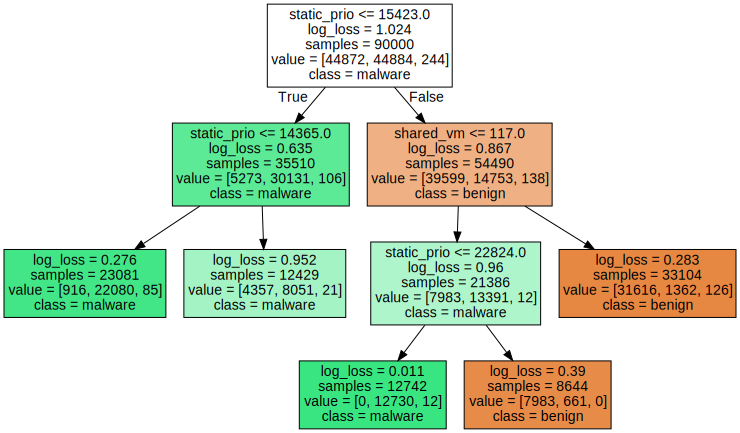

In [16]:
from sklearn import tree
import graphviz

clf=DecisionTreeClassifier(criterion='log_loss', max_depth=10, 
                           max_leaf_nodes = 5, ccp_alpha = 0.0,
                          min_samples_split=2,
                          min_impurity_decrease=0.02)
rst = cross_validate(clf, x, y, cv=10, scoring='accuracy', return_estimator=True)
# get fitted trees for each fold
trees = rst['estimator']
# print accuracy scores for each fold
scores = rst['test_score']
print(scores)

# select the best model  #not sure which is the best model?
clf = trees[2]

# encode labels
labels = le.inverse_transform([0,1,2])

print('features: ', x.columns.to_list())
print('labels: ', labels)


# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=x.columns.to_list(),  
                                class_names=labels,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
# save graph to MyDecisionTree.png
graph.render("MyDecisionTree")
graph